In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours

In [2]:
data = pd.read_csv('./dataset/kdd_cup99_10_percent.csv')
labels = ['dos','normal','prode','r2l','u2r']

In [3]:
Y = data[['attack_type_digit']]
X = data.drop(['label','label_digit','attack_type','attack_type_digit','service'], axis=1)

In [4]:
# Split test and train data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [8]:
from pyod.models.auto_encoder import AutoEncoder
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# 初始化 AutoEncoder
clf = AutoEncoder(contamination=0.1)

# 训练模型
clf.fit(X_train)

# 获取预测分数（用于多分类 ROC-AUC）
y_test_scores = clf.decision_function(X_test)  # 模型输出分数

# 将 y_test 转换为二进制格式
y_test_binary = label_binarize(Y_test, classes=[0, 1, 2, 3, 4])  # 对应类别 ['dos', 'normal', 'probe', 'r2l', 'u2r']


Training: 100%|██████████| 10/10 [06:46<00:00, 40.68s/it]


ValueError: Expected 2D array, got 1D array instead:
array=[0.18170224 0.18170224 0.18170224 ... 0.8540148  0.808516   0.1817022 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [10]:
import numpy as np

# 创建假设的多分类分数 (示例：使用反比例方法映射分数)
n_classes = y_test_binary.shape[1]  # 类别数
y_test_scores_expanded = np.tile(y_test_scores.reshape(-1, 1), n_classes)

# 确保分数和类别匹配 (这里需要根据任务实际调整)
print("Expanded y_test_scores shape:", y_test_scores_expanded.shape)


Expanded y_test_scores shape: (163027, 5)


In [15]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_test_scores_expanded, target_names=['dos', 'normal', 'probe', 'r2l', 'u2r']))


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [11]:
# 计算多分类 ROC-AUC
roc_auc_ovo = roc_auc_score(y_test_binary, y_test_scores_expanded, multi_class='ovo', average='macro')
roc_auc_ovr = roc_auc_score(y_test_binary, y_test_scores_expanded, multi_class='ovr', average='macro')

print(f"Multiclass ROC-AUC (OVO): {roc_auc_ovo}")
print(f"Multiclass ROC-AUC (OVR): {roc_auc_ovr}")

Multiclass ROC-AUC (OVO): 0.7862285060957014
Multiclass ROC-AUC (OVR): 0.7862285060957014


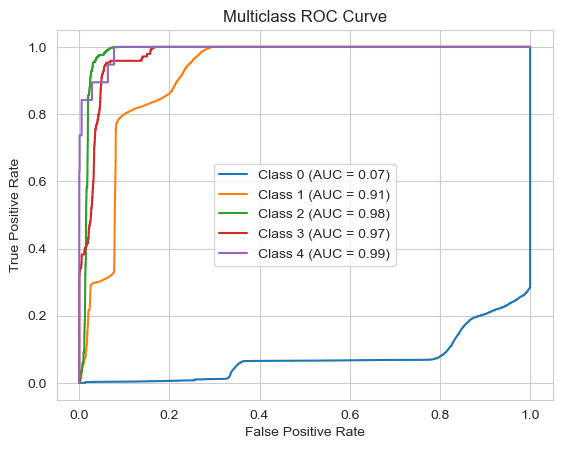

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 绘制每个类别的 ROC 曲线
for i in range(5):  # 五个类别
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_test_scores_expanded[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.title("Multiclass ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
